In [78]:
import os
import zipfile

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/kaggle_dataset"

In [81]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content/drive/MyDrive/kaggle_dataset. Or use the environment method.


In [82]:
Zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip")
Zip_ref.extractall("/tmp")
Zip_ref.close()

**Import Required Libraries::**

In [83]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [84]:
data_dir ="/tmp/flowers"

In [85]:
print(os.listdir("/tmp/flowers"))

['daisy', 'tulip', 'dandelion', 'rose', 'sunflower']


**Load using keras.preprocessing**

**Create a dataset::**

*Define some parameters for the loader:*

In [86]:
batch_size = 32
img_height = 180
img_width = 180

*It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.*

In [87]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.


In [88]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4317 files belonging to 5 classes.
Using 863 files for validation.


*You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.*

In [89]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


**Visualize the data::**

*Here are the first 9 images from the training dataset.*

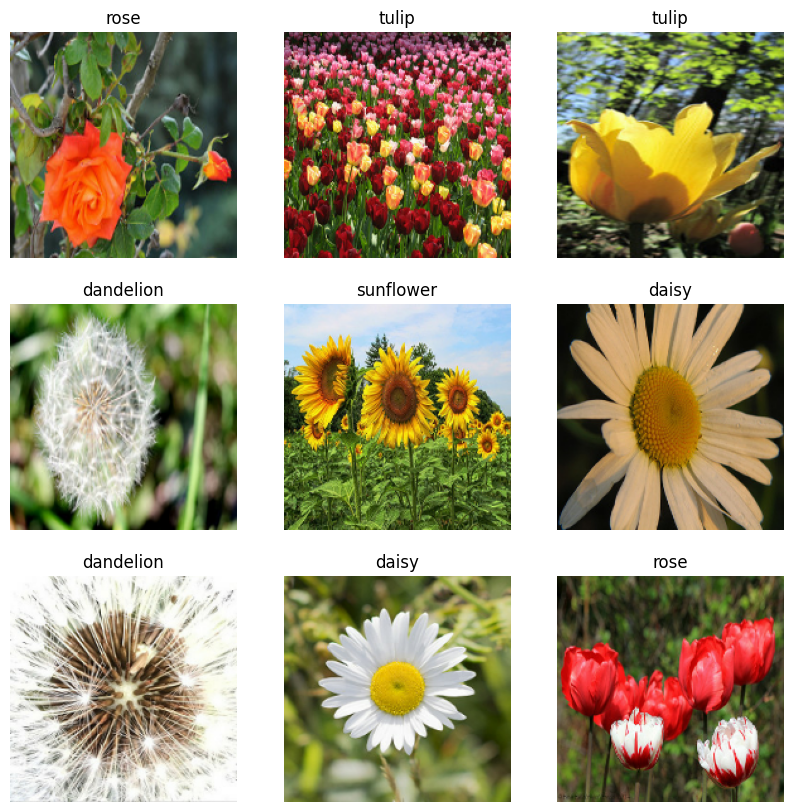

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

*You will train a model using these datasets by passing them to model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:*

In [91]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


*The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.*

**Configure the dataset for performance::**

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [92]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data::**

*The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.*

In [93]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

*There are two ways to use this layer. You can apply it to the dataset by calling map::*

In [94]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


**Create the model::**

*The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.*

In [95]:
num_classes = 5
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**compile the model::**

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [97]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
108/108 [==============================] - 7s 44ms/step - loss: 1.2917 - accuracy: 0.4299 - val_loss: 1.0224 - val_accuracy: 0.5898
Epoch 2/10
108/108 [==============================] - 2s 23ms/step - loss: 0.9898 - accuracy: 0.6112 - val_loss: 0.9029 - val_accuracy: 0.6327
Epoch 3/10
108/108 [==============================] - 3s 24ms/step - loss: 0.8641 - accuracy: 0.6566 - val_loss: 0.9064 - val_accuracy: 0.6292
Epoch 4/10
108/108 [==============================] - 3s 23ms/step - loss: 0.7759 - accuracy: 0.6963 - val_loss: 0.9492 - val_accuracy: 0.6362
Epoch 5/10
108/108 [==============================] - 2s 23ms/step - loss: 0.6492 - accuracy: 0.7577 - val_loss: 1.0635 - val_accuracy: 0.6211
Epoch 6/10
108/108 [==============================] - 2s 23ms/step - loss: 0.4963 - accuracy: 0.8162 - val_loss: 0.9508 - val_accuracy: 0.6408
Epoch 7/10
108/108 [==============================] - 2s 22ms/step - loss: 0.3888 - accuracy: 0.8526 - val_loss: 1.0738 - val_accuracy: 0.6744

**Visualize training results::**

Create plots of loss and accuracy on the training and validation sets.

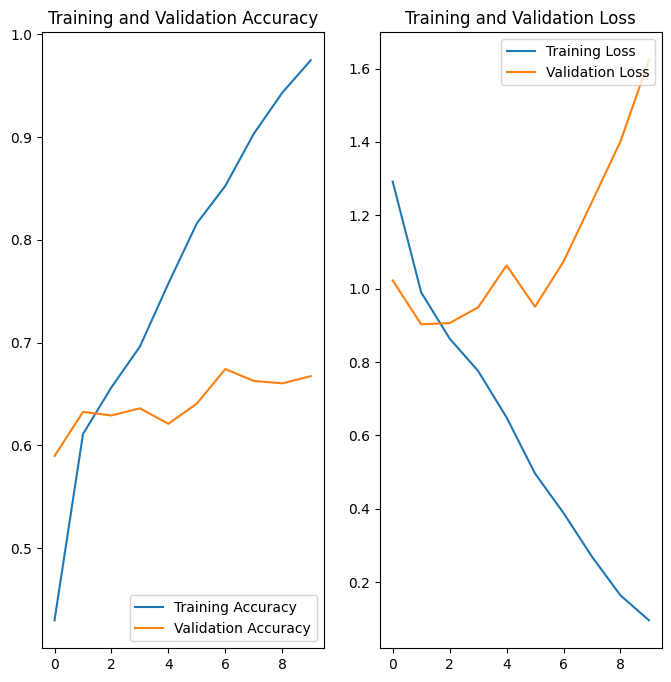

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Overfitting::**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

**Data augmentation::**

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside your model like other layers, and run on the GPU.

In [99]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

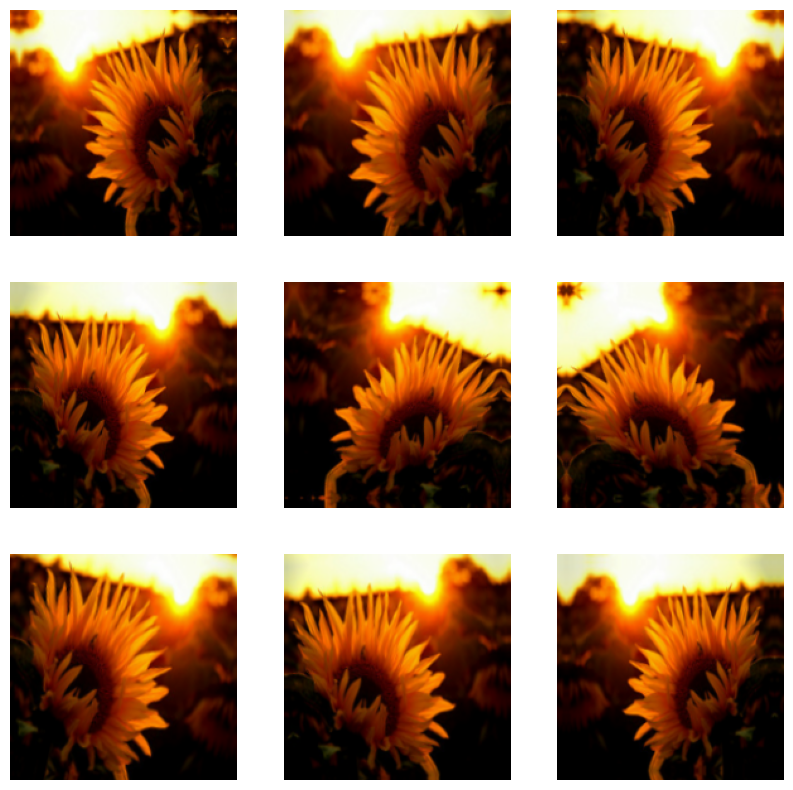

In [100]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout::**

Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using layers.Dropout, then train it using augmented images.

In [101]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [102]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [103]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [104]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)





Epoch 1/20
108/108 [==============================] - 6s 32ms/step - loss: 1.3404 - accuracy: 0.4340 - val_loss: 1.0909 - val_accuracy: 0.5400
Epoch 2/20
108/108 [==============================] - 3s 31ms/step - loss: 1.0971 - accuracy: 0.5550 - val_loss: 1.0528 - val_accuracy: 0.5701
Epoch 3/20
108/108 [==============================] - 3s 32ms/step - loss: 0.9875 - accuracy: 0.6120 - val_loss: 1.0439 - val_accuracy: 0.5759
Epoch 4/20
108/108 [==============================] - 3s 30ms/step - loss: 0.9213 - accuracy: 0.6453 - val_loss: 0.9063 - val_accuracy: 0.6338
Epoch 5/20
108/108 [==============================] - 3s 30ms/step - loss: 0.8738 - accuracy: 0.6679 - val_loss: 0.9893 - val_accuracy: 0.6257
Epoch 6/20
108/108 [==============================] - 3s 30ms/step - loss: 0.8056 - accuracy: 0.6812 - val_loss: 0.8441 - val_accuracy: 0.6616
Epoch 7/20
108/108 [==============================] - 3s 32ms/step - loss: 0.7795 - accuracy: 0.7044 - val_loss: 0.8824 - val_accuracy: 0.6559

**Visualize training results::**

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

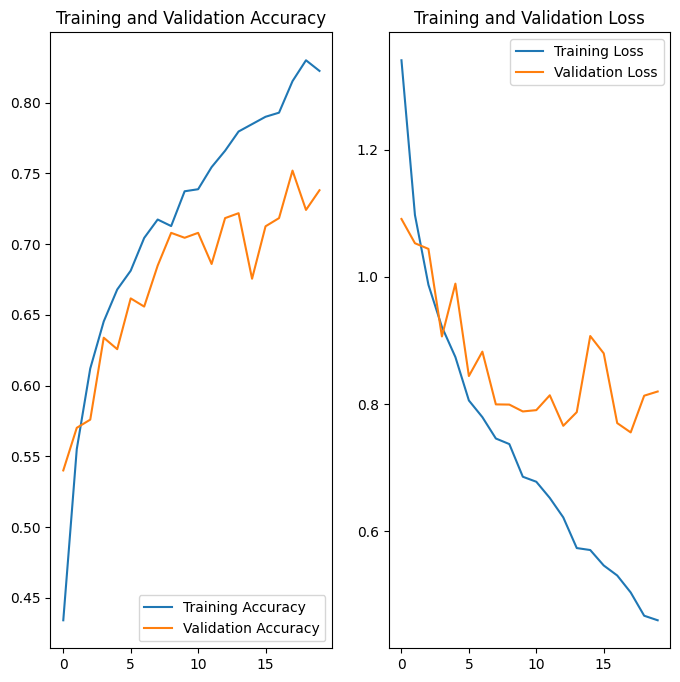

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Deploy model on colab.**

List classes with numbers of classes:

'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4

In [112]:
import numpy as np

from google.colab import files
import keras.utils as image

uploaded=files.upload()

Saving 6953297_8576bf4ea3.jpg to 6953297_8576bf4ea3.jpg


In [113]:
for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(180, 180))
  
  x=image.img_to_array(img)
  test_img=np.expand_dims(x, axis=0)
  
  
  result = model.predict(test_img)
  pred = np.argmax(result) # get the index of max value

  print(pred)

1/1 [==============================] - 0s 21ms/step
3
